In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
import pandas as pd
import torch.optim as optim

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [3]:
dataset_root_dir = "/datasets/COCO-2015"

In [4]:
from os import listdir
from os.path import isfile, join
listdir(dataset_root_dir)

['val2014', 'test2015', 'train2014']

In [5]:
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224),small_scale=True):
        super(COCODataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        if mode == "train":
            image_dir = join(root_dir, "train2014")     
        else:
            image_dir = join(root_dir,"val2014")
        index = 0
        data_dict = {}
        for file in listdir(image_dir):
            if file.endswith(".jpg"):
                data_dict[index]= join(image_dir,file)
                index += 1
        self.data = pd.Series(data_dict)
        if small_scale:
            self.data = self.data.iloc[:(len(self.data)//10)]
#         self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
#         self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
                                        ])
        x = transform(img)
        return x

In [6]:
train_COCO = COCODataset(dataset_root_dir,small_scale=False)
val_COCO = COCODataset(dataset_root_dir)

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
#     image = (image + 1) / 2
#     image[image < 0] = 0
#     image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [8]:
x = train_COCO.__getitem__(10)
len(train_COCO)

82783

<IPython.core.display.Javascript object>


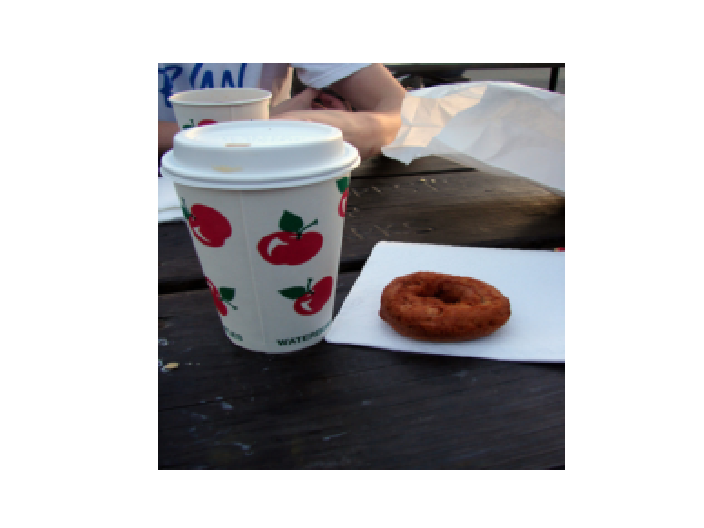

In [9]:
plt.figure(0)
myimshow(x)

In [11]:
style_root_dir = "./style"

In [12]:
class styleImage():
    def __init__(self, root_dir, image_name ,image_size=(224, 224)):
        self.image_size = image_size
        self.images_dir = join(root_dir, image_name)
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            # COMPLETE
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor()])
        x = transform(img)
        return x

In [13]:
style_image = styleImage(style_root_dir,"the_starry_night.jpg")

<IPython.core.display.Javascript object>


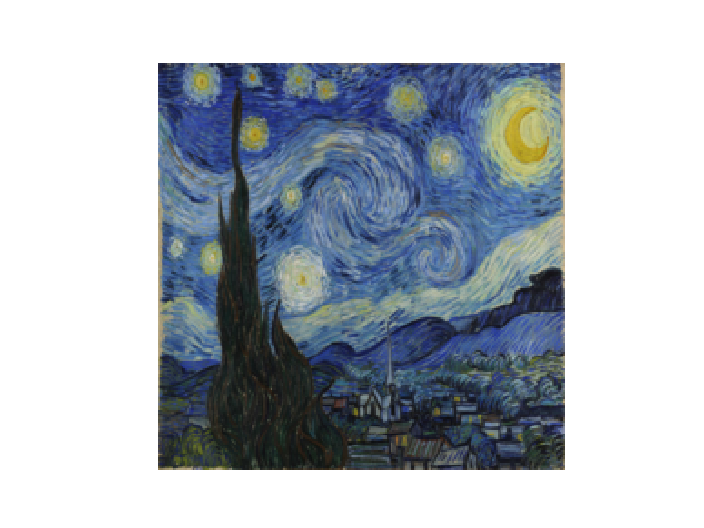

In [14]:
s_x = style_image.__getitem__(0)
plt.figure(1)
myimshow(s_x)

# Task 1 recap: Pre-trained VGG 

In [15]:
vgg = tv.models.vgg16(pretrained=True).features.to(device).eval()

In [16]:
class contentLoss(nn.Module):
    def __init__(self,target):
        super(contentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self,input):
#         print(input.shape, self.target.shape)
        self.loss = F.mse_loss(input, self.target)
        return input

In [17]:
def gram(input):
    batch_size, channel, height, width = input.shape
    x = input.view(batch_size*channel, height*width)
    return torch.mm(x, x.t())/(batch_size*channel*height*width)

In [18]:
class styleLoss(nn.Module):
    def __init__(self, target):
        super(styleLoss, self).__init__()
        self.target = target
        
        
    def forward(self, input):
        batch_size, channel, height, width = input.shape
        target_gram = gram(self.target)
        input_gram = gram(input)
        self.loss = F.mse_loss(input_gram, target_gram)*batch_size*channel*height*width
        return input

In [19]:
def constructModel(model, contentImg, styleImg, contentLayers, styleLayers):
    contentLoss_list = []
    styleLoss_list = []

    newModel = nn.Sequential()

    convCount = 0
    poolCount = 0
    reluCount = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            convCount += 1
            name = 'conv_'+str(convCount)
            newModel.add_module(name, layer)
            if name in contentLayers:
                content = newModel(contentImg)
                content_loss = contentLoss(content)
                newModel.add_module("content_loss_"+str(convCount), content_loss)
                contentLoss_list.append(content_loss)

            if name in styleLayers:
                style = newModel(styleImg).detach()
                style_loss = styleLoss(style)
                newModel.add_module("style_loss_"+str(convCount), style_loss)
                styleLoss_list.append(style_loss)
        if isinstance(layer, nn.ReLU):
            reluCount += 1
            name = 'relu_'+str(reluCount)
            layer = nn.ReLU(inplace=False)
            newModel.add_module(name, layer)
        if isinstance(layer, nn.MaxPool2d):
            poolCount += 1
            name = 'pool_'+str(poolCount)
            newModel.add_module(name, nn.AvgPool2d((2,2)))

    return newModel, styleLoss_list, contentLoss_list

In [20]:
def trainHelper(contentImg, styleImg, epoch, model, contentLayers, styleLayers, beta):
    trainImg = contentImg
    input_param = trainImg.requires_grad_()
    optimizer = optim.LBFGS([input_param])
    newModel,styleLoss_list,contentLoss_list = constructModel(model, contentImg, styleImg, contentLayers, styleLayers )
    i = [0]
    while i[0] <= epoch:
        def closure():
            trainImg.data.clamp(0,1)
            optimizer.zero_grad()
            newModel(trainImg)
            content_loss = 0
            style_loss = 0
            for loss_val in contentLoss_list:
                content_loss += loss_val.loss
            for loss_val in styleLoss_list:
                style_loss += loss_val.loss
            totalLoss = content_loss * 1 + style_loss * beta
#             print(totalLoss)
            totalLoss.backward()
            i[0] += 1
            #if i[0] % 50 == 0:
                #print("epoch:" + str(i[0]))
                #print("Style Loss :" + str(style_loss))
                #print("Content Loss :" + str(content_loss))
            return totalLoss
        optimizer.step(closure)
    trainImg.data.clamp_(0,1)
    return trainImg,newModel

In [21]:
def core(newModel, trainImg, optimizer, contentLoss_list, styleLoss_list, i):
    trainImg.data.clamp(0,1)
    optimizer.zero_grad()
    newModel(trainImg)
    content_loss = 0
    style_loss = 0
    for loss_val in contentLoss_list:
        content_loss += loss_val.loss
    for loss_val in styleLoss_list:
        style_loss += loss_val.loss
    totalLoss = content_loss * 1 + style_loss * 100000
    totalLoss.backward()
    i[0] += 1
    #if i[0] % 50 == 0:
        #print("epoch:" + str(i[0]))
        #print("Style Loss :" + str(style_loss))
        #print("Content Loss :" + str(content_loss))
    return totalLoss

In [22]:
x = x.unsqueeze(0)
x = x.to(device,torch.float)
s_x = s_x.unsqueeze(0)
s_x = s_x.to(device,torch.float)

<IPython.core.display.Javascript object>


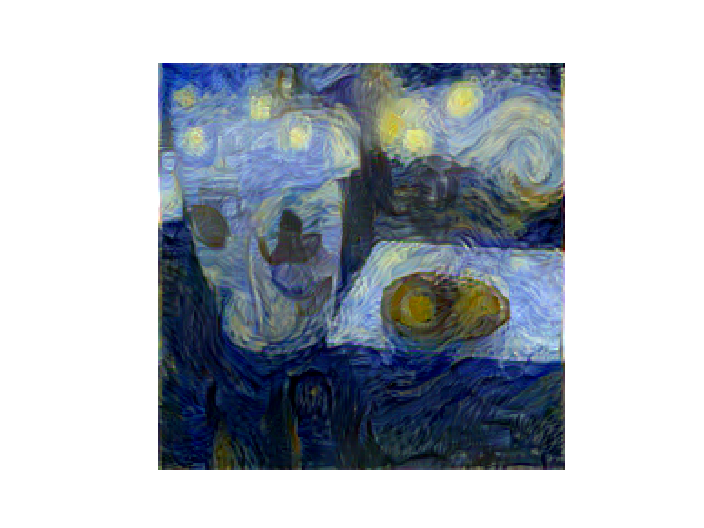

In [23]:
contentLayers = ['conv_7']
styleLayers = [['conv_2', 'conv_4', 'conv_7', 'conv_10']]
for i in range(len(styleLayers)):
    outputImg,newModel = trainHelper(x, s_x, 300, vgg, contentLayers, styleLayers[i], 10000)
    plt.figure(3)
    outputImg = outputImg.squeeze(0)
    myimshow(outputImg.detach(), ax=plt)

In [24]:
nn.Sequential(*list(newModel.children())[:-1])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): styleLoss()
  (4): ReLU()
  (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): styleLoss()
  (10): ReLU()
  (11): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): contentLoss()
  (18): styleLoss()
  (19): ReLU()
  (20): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (21): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (22): ReLU()
  

# Task 2: real time transfer, Train ResNet 

## 1.Residual Block 

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, 
                 out_channels, 
                 padding, 
                 norm_layer, 
                 dropout, 
                 bias,
                 non_lin):
        super(ResidualBlock,self).__init__()
###################################################################


#         in_channels:                    # of input channels
#         out_channels:                   # of output channels
#         padding:                         padding mode
#          norm_layer, :                "batchnorm" or "instancenorm"
#         droupout:                     boolean variable, if Ture use a droup out of 0.5
#         bias:                         boolean variable, if True, set bias of conved to true
#         non_lin                       non_linearity layer


######################################################################
        super(ResidualBlock, self).__init__()
        self.block = []
        conv1 = ConvLayer(in_channels, 
                          out_channels, 
                          kernel_size=3, 
                          stride=1,
                          padding=padding,bias=bias)
        self.block += [conv1]
        
        if norm_layer == "InstanceNorm":
            normal_layer = nn.InstanceNorm2d(in_channels)
        else:
            normal_layer = nn.BatchNorm2d(in_channels)
            
        self.block += [normal_layer,non_lin]
        if dropout:
            self.block += [nn.Dropout(0.5)]
        self.block += [conv1]
        self.block += [normal_layer]
        self.forward_func = nn.Sequential(*self.block)
    
    def forward(self, x):
        return x + self.forward_func(x)
    
    
class ConvLayer(nn.Module):
    def __init__(self, in_channels, 
                 out_channels,  
                 kernel_size,
                 stride,
                 padding,
                 bias):
        super(ConvLayer, self).__init__()
        self.block = []
        p = 0
        if padding == "reflect":
            self.block.append(nn.ReflectionPad2d(kernel_size//2))

        elif padding == "replicate":
            self.block.append(nn.ReplicationPad2d(kernel_size//2))

        else:
            p = 1
        self.block.append( nn.Conv2d(in_channels,
                                    out_channels, 
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding=p, 
                                    bias=bias) )
        self.forward_func = nn.Sequential(*self.block)

    def forward(self,x):
        return self.forward_func(x)
    
    

## 2. Resnet constructor 

In [47]:
class ResNetGen(nn.Module):
    def __init__(self,
                 in_channels, 
                 out_channels, 
                 ngf,
                 padding, 
                 norm_layer, 
                 dropout, 
                 num_resblocks,
                 num_down_samp):
        super(ResNetGen,self).__init__()
#############################################################################################


#         in_channels:                    # of input channels
#         out_channels:                   # of output channels
#         ngf                             # of filters in the first conv layer
#         padding:                         padding mode
#         norm_layer:                      batch normal layer created outside of this class
#         droupout:                     boolean variable, if Ture use a droup out of 0.5
#         bias:                         boolean variable, if True, set bias of conved to true
#         num_resblocks                 number of residual blocks
#         num_down_samp                 number of down sampling
#                                       each contains a conv with stride 2


#############################################################################################
        bias = True
        net = [nn.ReflectionPad2d(4),
                 nn.Conv2d(in_channels,ngf, kernel_size=9,padding=0,bias=bias)
                ]
        if norm_layer == "InstanceNorm":
            net += [nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]
        else:
            net += [nn.BatchNorm2d(ngf),
                 nn.ReLU(True)]
        
        # downsampling
        for i in range(num_down_samp):
            mult = 2**i
            net += [nn.Conv2d(ngf*mult,ngf*mult*2, kernel_size=3, 
                              stride=2,padding=1, bias=bias)]
                   
            if norm_layer == "InstanceNorm":
                net += [nn.InstanceNorm2d(ngf*mult*2),
                     nn.ReLU(True)]
            else:
                net += [nn.BatchNorm2d(ngf*mult*2),
                     nn.ReLU(True)]  
                
        mult = mult * 2
        
        for i in range(num_resblocks):
            net += [ResidualBlock(in_channels=ngf*mult, 
                 out_channels=ngf*mult, 
                 padding=padding, 
                 norm_layer=norm_layer, 
                 dropout=dropout, 
                 bias=bias,
                 non_lin=nn.ReLU(True))]
            
        # upsampling   
        for i in range(num_down_samp):
            mult = 2**(num_down_samp-i)
            net += [nn.ConvTranspose2d(ngf*mult, 
                                       ngf*mult//2,
                                      kernel_size = 3,
                                      stride=2,
                                      padding=1,
                                      output_padding=1,
                                      bias = bias)]
                   
            if norm_layer == "InstanceNorm":
                net += [nn.InstanceNorm2d(ngf*mult//2),
                     nn.ReLU(True)]
            else:
                net += [nn.BatchNorm2d(ngf*mult//2),
                     nn.ReLU(True)]  

            
        net += [nn.ReflectionPad2d(4),
               nn.Conv2d(ngf,out_channels,kernel_size=9,padding=0),
               nn.Tanh()]
        self.net = nn.Sequential(*net)
        
    def forward(self,x):
        return self.net(x)

In [48]:
style_transfer = ResNetGen(3,3,64,"reflect","BatchNorm",False,5,2)

In [49]:
style_transfer

ResNetGen(
  (net): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (forward_func): Sequential(
        (0): ConvLayer(
          (forward_func): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)


## 3.LossNetwork construction class

In [50]:
from collections import namedtuple

# reference : https://github.com/ceshine/fast-neural-style/blob/master/fast_neural_style/loss_network.py
# since the features are extract from relu instad of conv in task 1, the network has to be reconstructed
LossOutput = namedtuple("LossOutput", ["relu1", "relu2", "relu3", "relu4"])
class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork,self).__init__()
        self.vgg_layers = tv.models.vgg.vgg16(pretrained=True).features
        self.layer_name_mapping={
            '3':"relu1",
            '8':"relu2",
            '15':"relu3",
            '22':"relu4"
        }
        
    def forward(self,x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

##  4.gram matrix calculator

In [51]:
def gram_matrix(y):
    (b,ch,h,w) = y.shape
    features = y.view(b,ch,w*h)
    feature_t = features.transpose(1,2)
    gram = features.bmm(feature_t) / (ch*h*w)
    return gram

## 5.Funciton to Recover image from normalized image 

In [75]:
def recover_image(img):
    return (
        (
#             img *
#             np.array([0.229, 0.224, 0.225]).reshape((1, 3, 1, 1)) +
#             np.array([0.485, 0.456, 0.406]).reshape((1, 3, 1, 1))
            
            img *
            np.array([0.5, 0.5, 0.5]).reshape((1, 3, 1, 1)) +
            np.array([0.5, 0.5, 0.5]).reshape((1, 3, 1, 1))
        ).transpose(0, 2, 3, 1) *
        255.
    ).clip(0, 255).astype(np.uint8)

In [53]:
class styleImage():
    def __init__(self, root_dir, image_name ,image_size=(256, 256)):
        self.image_size = image_size
        self.images_dir = join(root_dir, image_name)
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            # COMPLETE
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
#             tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])]
             tv.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])]
        )
        x = transform(img).unsqueeze(0)
        return x

<IPython.core.display.Javascript object>


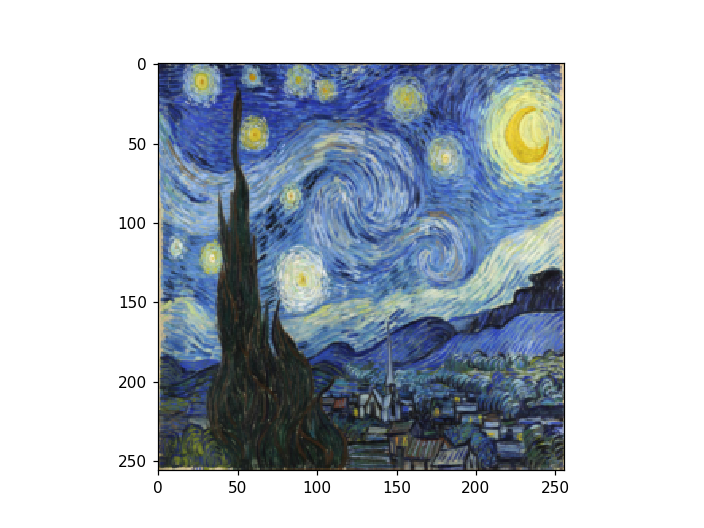

In [54]:
style_img = styleImage(style_root_dir,"the_starry_night.jpg")
style_img = style_img.__getitem__(0)
plt.figure(4)
plt.imshow(recover_image(style_img.cpu().numpy())[0])


In [55]:
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1

## 6. Calculate the gram of style image 

In [56]:
with torch.no_grad():
    style_img = style_img.to(device)
    style_loss_features = loss_network(style_img)
    gram_style = [gram_matrix(y) for y in style_loss_features]

## 7.Data loader to load normalized content train set 

In [57]:
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(256, 256),small_scale=True):
        super(COCODataset, self).__init__()
        
#################################################################

#     root_dir:          root directory of the training set 
#     mode:              mode, train or validation(not used in this project) 
#     image_size:         length and withd of the output image 
#     small_scale=True:   if small scale is set to True, the loader only load 
#                         1/10 of the training data


#################################################################
        self.image_size = image_size
        self.mode = mode
        if mode == "train":
            image_dir = join(root_dir, "train2014")     
        else:
            image_dir = join(root_dir,"val2014")
        index = 0
        data_dict = {}
        for file in listdir(image_dir):
            if file.endswith(".jpg"):
                data_dict[index]= join(image_dir,file)
                index += 1
        self.data = pd.Series(data_dict)
        if small_scale:
            self.data = self.data.iloc[:(len(self.data)//10)]
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]
        img = Image.open(img_path).convert('RGB')
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
#                                            tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])
                                           tv.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                  std=[0.5, 0.5, 0.5])
                                        ])
        x = transform(img)
        return x

In [58]:
train_COCO = COCODataset(dataset_root_dir,small_scale=True)
len(train_COCO)

8278

In [59]:
train_loader = td.DataLoader(train_COCO, batch_size=4, shuffle=True,drop_last=True)

In [86]:
def RT_transfer_train(loss_network, 
                      gen_resnet,
                      style_image,
                      train_loader,
                      num_epochs,
                      beta,
                      optimizer='adam'):
    gen_resnet = gen_resnet.to(device)
    loss_network = loss_network.to(device)
######################################################################

# input parameters:
#     loss_network:  container of loss_network, should be an instance of class drived from nn.Module  
#     gen_resnet:    container of the resnet
#     style_image:   style_image
#     train_loader:  train loader
#     num_epochs:    number of epoch
#     beta:          the style loss will multiplied by beta
#     optimizer:     default is adam optimizer   

# output :
# gen_resent:        containter of trained resnet 

######################################################################
    if optimizer == 'adam':
        optimizer = optim.Adam(gen_resnet.parameters())
   

    
#reference: https://github.com/ceshine/fast-neural-style/blob/master/notebooks/01-image-style-transfer.ipynb
    
    
    CONTENT_WEIGHT = 1
#     STYLE_WEIGHT = np.array([1e-1, 1, 1e1, 5, 1e1])*beta
    STYLE_WEIGHT = np.array([5e-1, 1, 1e1, 5])*beta
#     STYLE_WEIGHT = np.array([5e-1, 5, 1e1, 5, 1e1])*beta
#     STYLE_WEIGHT = np.array([1, 1, 1, 1])*beta
#     STYLE_WEIGHT = np.array([2e-1, 2e-1, 2e-1, 2e-1, 2e-1])*beta
    REGULARIZATION = 1e-5
    mse_loss = nn.MSELoss()
    for e in range(num_epochs):
        gen_resnet.train()
        
        image_count = 0
        
#         if e == 1:
#             STYLE_WEIGHT = STYLE_WEIGHT*5
            
        
        for x in train_loader:
            image_count += 4
            optimizer.zero_grad()
            x = x.to(device)
            y = gen_resnet(x)
            
            with torch.no_grad():
                xc = x.detach()
                
            features_y = loss_network(y)
            features_xc = loss_network(xc)
            
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()
            
            
            content_loss = CONTENT_WEIGHT * mse_loss(features_y[2],f_xc_c)
            reg_loss = REGULARIZATION * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))
            
            style_loss = 0
            for l, weight in enumerate(STYLE_WEIGHT):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                c, w, h = gram_y.shape
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y)) 
                
            total_loss = content_loss + style_loss + reg_loss
            print('total: ', total_loss.item(),
                  ' style: ', style_loss.item(),
                  ' content: ', content_loss.item(),
                  ' count: ', image_count, ' epoch: ',e)
            total_loss.backward()
            optimizer.step()

            
            


    return gen_resnet

In [87]:
device

'cuda'

In [88]:
style_transfer = ResNetGen(3,3,32,"reflect","BatchNorm",False,5,2)

In [89]:

gen_resnet = RT_transfer_train(loss_network,style_transfer,style_img,train_loader,2,3e5,'adam')



total:  133.25173950195312  style:  120.75421905517578  content:  8.745811462402344  count:  4  epoch:  0
total:  2751.405029296875  style:  2731.648193359375  content:  14.527277946472168  count:  8  epoch:  0
total:  844.9154663085938  style:  829.8866577148438  content:  10.412542343139648  count:  12  epoch:  0
total:  505.0489807128906  style:  492.49273681640625  content:  8.434053421020508  count:  16  epoch:  0
total:  254.89019775390625  style:  242.0457763671875  content:  9.354180335998535  count:  20  epoch:  0
total:  183.50279235839844  style:  172.9134979248047  content:  7.254171371459961  count:  24  epoch:  0
total:  135.58111572265625  style:  125.28851318359375  content:  7.837693214416504  count:  28  epoch:  0
total:  152.61253356933594  style:  140.88662719726562  content:  8.94624137878418  count:  32  epoch:  0
total:  159.4232635498047  style:  147.8509063720703  content:  8.606772422790527  count:  36  epoch:  0
total:  153.33218383789062  style:  143.3501892

total:  79.34783172607422  style:  70.16732788085938  content:  7.637265205383301  count:  316  epoch:  0
total:  77.41346740722656  style:  70.7944107055664  content:  4.740447521209717  count:  320  epoch:  0
total:  76.50811767578125  style:  67.0083999633789  content:  7.3666768074035645  count:  324  epoch:  0
total:  78.8970947265625  style:  70.7018814086914  content:  6.275341510772705  count:  328  epoch:  0
total:  77.30497741699219  style:  67.698974609375  content:  7.574061393737793  count:  332  epoch:  0
total:  77.68241119384766  style:  68.29491424560547  content:  7.459468364715576  count:  336  epoch:  0
total:  76.91925048828125  style:  66.83152770996094  content:  8.30496883392334  count:  340  epoch:  0
total:  80.64842224121094  style:  73.0855941772461  content:  5.961094856262207  count:  344  epoch:  0
total:  80.7283706665039  style:  73.64777374267578  content:  5.48969030380249  count:  348  epoch:  0
total:  74.80661010742188  style:  63.547393798828125  

total:  61.136322021484375  style:  49.29893112182617  content:  9.645857810974121  count:  628  epoch:  0
total:  59.73767852783203  style:  49.01010513305664  content:  8.60692310333252  count:  632  epoch:  0
total:  60.90765380859375  style:  50.1264762878418  content:  8.496479034423828  count:  636  epoch:  0
total:  64.3839111328125  style:  55.65886306762695  content:  6.798710346221924  count:  640  epoch:  0
total:  62.81576919555664  style:  54.201942443847656  content:  6.316032409667969  count:  644  epoch:  0
total:  62.758697509765625  style:  54.08985137939453  content:  6.4922685623168945  count:  648  epoch:  0
total:  62.27214431762695  style:  49.47294235229492  content:  10.422117233276367  count:  652  epoch:  0
total:  55.91750717163086  style:  47.40683364868164  content:  6.291650295257568  count:  656  epoch:  0
total:  57.005340576171875  style:  47.20143508911133  content:  7.388909816741943  count:  660  epoch:  0
total:  55.65794372558594  style:  44.57755

total:  38.15718078613281  style:  25.482709884643555  content:  9.83842945098877  count:  940  epoch:  0
total:  38.869102478027344  style:  25.1557559967041  content:  10.92473316192627  count:  944  epoch:  0
total:  37.67558288574219  style:  24.731346130371094  content:  10.17172622680664  count:  948  epoch:  0
total:  37.25762939453125  style:  26.36976432800293  content:  8.123294830322266  count:  952  epoch:  0
total:  37.85344314575195  style:  26.734020233154297  content:  8.478753089904785  count:  956  epoch:  0
total:  37.792076110839844  style:  25.28965187072754  content:  9.85396671295166  count:  960  epoch:  0
total:  40.046409606933594  style:  28.2977237701416  content:  8.99881649017334  count:  964  epoch:  0
total:  36.81414031982422  style:  23.083158493041992  content:  11.048432350158691  count:  968  epoch:  0
total:  45.74919509887695  style:  34.336082458496094  content:  8.83086109161377  count:  972  epoch:  0
total:  38.979679107666016  style:  27.0316

total:  31.735387802124023  style:  17.611894607543945  content:  11.610733032226562  count:  1252  epoch:  0
total:  31.048585891723633  style:  19.472354888916016  content:  9.388911247253418  count:  1256  epoch:  0
total:  31.450246810913086  style:  18.987455368041992  content:  10.00065803527832  count:  1260  epoch:  0
total:  32.69242858886719  style:  21.12071990966797  content:  9.206298828125  count:  1264  epoch:  0
total:  30.951160430908203  style:  20.19197654724121  content:  8.440601348876953  count:  1268  epoch:  0
total:  29.717288970947266  style:  17.351675033569336  content:  10.04604434967041  count:  1272  epoch:  0
total:  27.48508071899414  style:  17.296735763549805  content:  7.928241729736328  count:  1276  epoch:  0
total:  30.3199405670166  style:  18.758193969726562  content:  9.201960563659668  count:  1280  epoch:  0
total:  30.63483238220215  style:  20.11136245727539  content:  8.100293159484863  count:  1284  epoch:  0
total:  29.531557083129883  s

total:  24.103864669799805  style:  14.299323081970215  content:  7.576416015625  count:  1556  epoch:  0
total:  24.499555587768555  style:  13.51552677154541  content:  8.758774757385254  count:  1560  epoch:  0
total:  27.343095779418945  style:  12.946603775024414  content:  12.098544120788574  count:  1564  epoch:  0
total:  25.604503631591797  style:  13.990330696105957  content:  9.449907302856445  count:  1568  epoch:  0
total:  25.666065216064453  style:  15.358296394348145  content:  8.197145462036133  count:  1572  epoch:  0
total:  25.15182876586914  style:  14.438912391662598  content:  8.55453109741211  count:  1576  epoch:  0
total:  30.783733367919922  style:  18.829816818237305  content:  9.888984680175781  count:  1580  epoch:  0
total:  25.48258399963379  style:  15.741158485412598  content:  7.698879718780518  count:  1584  epoch:  0
total:  24.572450637817383  style:  14.753987312316895  content:  7.7446112632751465  count:  1588  epoch:  0
total:  27.5324440002441

total:  22.36427116394043  style:  11.270631790161133  content:  9.134138107299805  count:  1860  epoch:  0
total:  25.99251365661621  style:  14.52474594116211  content:  9.491055488586426  count:  1864  epoch:  0
total:  24.309024810791016  style:  12.872832298278809  content:  9.324070930480957  count:  1868  epoch:  0
total:  23.666913986206055  style:  10.864829063415527  content:  10.774086952209473  count:  1872  epoch:  0
total:  24.927845001220703  style:  14.167078018188477  content:  8.84793758392334  count:  1876  epoch:  0
total:  24.456073760986328  style:  14.345819473266602  content:  8.176787376403809  count:  1880  epoch:  0
total:  24.034746170043945  style:  11.311981201171875  content:  10.719182014465332  count:  1884  epoch:  0
total:  24.158143997192383  style:  11.765405654907227  content:  10.367961883544922  count:  1888  epoch:  0
total:  24.532329559326172  style:  12.350438117980957  content:  10.271403312683105  count:  1892  epoch:  0
total:  23.72251319

total:  23.331573486328125  style:  11.537859916687012  content:  10.036754608154297  count:  2164  epoch:  0
total:  26.12320327758789  style:  17.43927001953125  content:  7.147363662719727  count:  2168  epoch:  0
total:  22.636838912963867  style:  9.510967254638672  content:  11.23768424987793  count:  2172  epoch:  0
total:  20.94883155822754  style:  10.560572624206543  content:  8.573139190673828  count:  2176  epoch:  0
total:  23.26942253112793  style:  11.195600509643555  content:  10.314921379089355  count:  2180  epoch:  0
total:  23.09423828125  style:  10.78989028930664  content:  10.54751205444336  count:  2184  epoch:  0
total:  23.578271865844727  style:  12.657147407531738  content:  9.214203834533691  count:  2188  epoch:  0
total:  22.085933685302734  style:  10.537982940673828  content:  9.745408058166504  count:  2192  epoch:  0
total:  23.397632598876953  style:  11.833388328552246  content:  9.747292518615723  count:  2196  epoch:  0
total:  21.844913482666016 

total:  23.479646682739258  style:  11.275288581848145  content:  10.552974700927734  count:  2468  epoch:  0
total:  21.164121627807617  style:  10.76335334777832  content:  8.818202018737793  count:  2472  epoch:  0
total:  20.82782745361328  style:  8.984301567077637  content:  10.150339126586914  count:  2476  epoch:  0
total:  21.313976287841797  style:  9.585474967956543  content:  10.054838180541992  count:  2480  epoch:  0
total:  21.292829513549805  style:  9.697274208068848  content:  9.918008804321289  count:  2484  epoch:  0
total:  21.650983810424805  style:  11.295694351196289  content:  8.780487060546875  count:  2488  epoch:  0
total:  22.650592803955078  style:  10.103413581848145  content:  10.914477348327637  count:  2492  epoch:  0
total:  21.69268226623535  style:  11.614509582519531  content:  8.478972434997559  count:  2496  epoch:  0
total:  18.43924331665039  style:  8.215469360351562  content:  8.45722770690918  count:  2500  epoch:  0
total:  20.5775413513183

total:  24.01004981994629  style:  13.263834953308105  content:  9.16120433807373  count:  2772  epoch:  0
total:  19.715051651000977  style:  8.334208488464355  content:  9.709733009338379  count:  2776  epoch:  0
total:  22.25436019897461  style:  8.519038200378418  content:  12.036611557006836  count:  2780  epoch:  0
total:  18.90357780456543  style:  9.522217750549316  content:  7.799351215362549  count:  2784  epoch:  0
total:  20.788606643676758  style:  8.380176544189453  content:  10.708706855773926  count:  2788  epoch:  0
total:  19.785171508789062  style:  8.78929615020752  content:  9.38117504119873  count:  2792  epoch:  0
total:  20.12333869934082  style:  9.328010559082031  content:  9.185139656066895  count:  2796  epoch:  0
total:  21.517057418823242  style:  10.306190490722656  content:  9.64852523803711  count:  2800  epoch:  0
total:  19.016279220581055  style:  8.172174453735352  content:  9.191290855407715  count:  2804  epoch:  0
total:  22.724119186401367  styl

total:  21.05259132385254  style:  9.381719589233398  content:  10.11886978149414  count:  3076  epoch:  0
total:  21.492366790771484  style:  7.897588729858398  content:  11.948566436767578  count:  3080  epoch:  0
total:  21.205158233642578  style:  8.09387493133545  content:  11.497662544250488  count:  3084  epoch:  0
total:  18.978483200073242  style:  7.766195297241211  content:  9.605134010314941  count:  3088  epoch:  0
total:  22.689075469970703  style:  8.176373481750488  content:  12.873008728027344  count:  3092  epoch:  0
total:  18.000165939331055  style:  8.053339958190918  content:  8.35779094696045  count:  3096  epoch:  0
total:  19.253145217895508  style:  7.32237434387207  content:  10.321073532104492  count:  3100  epoch:  0
total:  18.899229049682617  style:  8.436610221862793  content:  8.912272453308105  count:  3104  epoch:  0
total:  18.870458602905273  style:  9.087132453918457  content:  8.241320610046387  count:  3108  epoch:  0
total:  20.555713653564453  

total:  19.186227798461914  style:  7.119384288787842  content:  10.487879753112793  count:  3380  epoch:  0
total:  19.85053062438965  style:  8.261183738708496  content:  10.067967414855957  count:  3384  epoch:  0
total:  18.5958194732666  style:  8.168910026550293  content:  8.879015922546387  count:  3388  epoch:  0
total:  20.23777198791504  style:  8.929181098937988  content:  9.819535255432129  count:  3392  epoch:  0
total:  19.206941604614258  style:  7.588480472564697  content:  10.094325065612793  count:  3396  epoch:  0
total:  21.443944931030273  style:  8.93575382232666  content:  11.013794898986816  count:  3400  epoch:  0
total:  18.726396560668945  style:  8.573984146118164  content:  8.634603500366211  count:  3404  epoch:  0
total:  20.8415470123291  style:  8.543362617492676  content:  10.764141082763672  count:  3408  epoch:  0
total:  21.0594482421875  style:  7.7371745109558105  content:  11.794095039367676  count:  3412  epoch:  0
total:  18.524703979492188  st

total:  19.200265884399414  style:  7.200398921966553  content:  10.549555778503418  count:  3684  epoch:  0
total:  18.778961181640625  style:  6.768240928649902  content:  10.543517112731934  count:  3688  epoch:  0
total:  22.282135009765625  style:  7.157166481018066  content:  13.628555297851562  count:  3692  epoch:  0
total:  17.878969192504883  style:  7.656293869018555  content:  8.751440048217773  count:  3696  epoch:  0
total:  19.714923858642578  style:  7.666712760925293  content:  10.564464569091797  count:  3700  epoch:  0
total:  17.75629997253418  style:  7.994665622711182  content:  8.279922485351562  count:  3704  epoch:  0
total:  18.673343658447266  style:  6.734238624572754  content:  10.451593399047852  count:  3708  epoch:  0
total:  19.230514526367188  style:  9.677482604980469  content:  8.215341567993164  count:  3712  epoch:  0
total:  19.589385986328125  style:  7.1332550048828125  content:  10.99478530883789  count:  3716  epoch:  0
total:  17.637119293212

total:  18.763423919677734  style:  8.213942527770996  content:  9.157093048095703  count:  3992  epoch:  0
total:  17.36757469177246  style:  6.522388458251953  content:  9.351588249206543  count:  3996  epoch:  0
total:  20.84243392944336  style:  6.563930988311768  content:  12.82876205444336  count:  4000  epoch:  0
total:  18.004480361938477  style:  7.077709197998047  content:  9.454436302185059  count:  4004  epoch:  0
total:  17.905845642089844  style:  7.580665111541748  content:  8.920787811279297  count:  4008  epoch:  0
total:  19.061861038208008  style:  8.116475105285645  content:  9.561071395874023  count:  4012  epoch:  0
total:  17.52202606201172  style:  6.525577545166016  content:  9.53464126586914  count:  4016  epoch:  0
total:  19.999919891357422  style:  7.399896144866943  content:  11.151622772216797  count:  4020  epoch:  0
total:  19.276168823242188  style:  7.223844528198242  content:  10.60710334777832  count:  4024  epoch:  0
total:  17.459186553955078  sty

total:  34.69210433959961  style:  21.75680923461914  content:  11.446868896484375  count:  4304  epoch:  0
total:  34.7321891784668  style:  26.80919647216797  content:  6.789623260498047  count:  4308  epoch:  0
total:  28.5712833404541  style:  16.308382034301758  content:  10.782048225402832  count:  4312  epoch:  0
total:  30.916271209716797  style:  19.760019302368164  content:  9.829404830932617  count:  4316  epoch:  0
total:  27.350004196166992  style:  16.945831298828125  content:  9.159427642822266  count:  4320  epoch:  0
total:  30.433406829833984  style:  22.201135635375977  content:  7.049909591674805  count:  4324  epoch:  0
total:  30.1878604888916  style:  17.08751106262207  content:  11.68856143951416  count:  4328  epoch:  0
total:  25.75040054321289  style:  15.726378440856934  content:  8.559643745422363  count:  4332  epoch:  0
total:  25.258745193481445  style:  15.277036666870117  content:  8.508831977844238  count:  4336  epoch:  0
total:  26.65802001953125  s

total:  23.49469566345215  style:  12.88785457611084  content:  9.181739807128906  count:  4608  epoch:  0
total:  22.655643463134766  style:  13.27151870727539  content:  8.010833740234375  count:  4612  epoch:  0
total:  24.62303352355957  style:  12.764430046081543  content:  10.379681587219238  count:  4616  epoch:  0
total:  23.567672729492188  style:  13.178765296936035  content:  9.093770027160645  count:  4620  epoch:  0
total:  23.28569984436035  style:  12.827430725097656  content:  9.113377571105957  count:  4624  epoch:  0
total:  25.35179901123047  style:  11.625777244567871  content:  12.273046493530273  count:  4628  epoch:  0
total:  22.575897216796875  style:  11.556941032409668  content:  9.54377555847168  count:  4632  epoch:  0
total:  24.432355880737305  style:  13.214262008666992  content:  9.90908145904541  count:  4636  epoch:  0
total:  23.36126708984375  style:  11.23020076751709  content:  10.69943904876709  count:  4640  epoch:  0
total:  22.634366989135742 

total:  22.05074691772461  style:  11.587234497070312  content:  9.070855140686035  count:  4912  epoch:  0
total:  21.476085662841797  style:  9.502702713012695  content:  10.517662048339844  count:  4916  epoch:  0
total:  22.477466583251953  style:  9.392059326171875  content:  11.637627601623535  count:  4920  epoch:  0
total:  21.079851150512695  style:  11.213486671447754  content:  8.561639785766602  count:  4924  epoch:  0
total:  22.495716094970703  style:  9.846317291259766  content:  11.230055809020996  count:  4928  epoch:  0
total:  22.17930030822754  style:  8.888602256774902  content:  11.911049842834473  count:  4932  epoch:  0
total:  20.998470306396484  style:  9.315643310546875  content:  10.253246307373047  count:  4936  epoch:  0
total:  20.600238800048828  style:  10.046944618225098  content:  9.238699913024902  count:  4940  epoch:  0
total:  21.1904296875  style:  10.082950592041016  content:  9.750195503234863  count:  4944  epoch:  0
total:  20.202058792114258

total:  20.131855010986328  style:  8.408926010131836  content:  10.385540962219238  count:  5216  epoch:  0
total:  20.721609115600586  style:  10.042694091796875  content:  9.32779598236084  count:  5220  epoch:  0
total:  21.00685691833496  style:  7.8946332931518555  content:  11.694296836853027  count:  5224  epoch:  0
total:  20.324542999267578  style:  10.97346019744873  content:  8.035297393798828  count:  5228  epoch:  0
total:  20.301040649414062  style:  8.13177490234375  content:  10.770573616027832  count:  5232  epoch:  0
total:  19.363557815551758  style:  9.38453197479248  content:  8.621636390686035  count:  5236  epoch:  0
total:  18.55780601501465  style:  8.880143165588379  content:  8.312376976013184  count:  5240  epoch:  0
total:  20.614788055419922  style:  8.230903625488281  content:  10.946579933166504  count:  5244  epoch:  0
total:  20.4754695892334  style:  8.664137840270996  content:  10.423012733459473  count:  5248  epoch:  0
total:  19.718673706054688  

total:  19.249544143676758  style:  8.881778717041016  content:  9.031222343444824  count:  5520  epoch:  0
total:  19.733482360839844  style:  7.887424468994141  content:  10.412252426147461  count:  5524  epoch:  0
total:  19.728374481201172  style:  8.226316452026367  content:  10.113009452819824  count:  5528  epoch:  0
total:  21.775527954101562  style:  11.311427116394043  content:  9.169683456420898  count:  5532  epoch:  0
total:  20.260814666748047  style:  8.694490432739258  content:  10.23331356048584  count:  5536  epoch:  0
total:  19.066560745239258  style:  8.00157356262207  content:  9.716347694396973  count:  5540  epoch:  0
total:  17.727705001831055  style:  7.641178131103516  content:  8.72080135345459  count:  5544  epoch:  0
total:  20.604101181030273  style:  8.883883476257324  content:  10.43704605102539  count:  5548  epoch:  0
total:  17.881587982177734  style:  7.505768775939941  content:  9.058829307556152  count:  5552  epoch:  0
total:  19.21053123474121  

total:  19.879467010498047  style:  10.055970191955566  content:  8.542928695678711  count:  5824  epoch:  0
total:  17.297630310058594  style:  7.336008071899414  content:  8.599305152893066  count:  5828  epoch:  0
total:  18.7164249420166  style:  7.568158149719238  content:  9.811117172241211  count:  5832  epoch:  0
total:  17.50749397277832  style:  7.520361423492432  content:  8.642885208129883  count:  5836  epoch:  0
total:  21.000232696533203  style:  8.066387176513672  content:  11.561744689941406  count:  5840  epoch:  0
total:  17.4151611328125  style:  6.959623336791992  content:  9.108392715454102  count:  5844  epoch:  0
total:  18.641313552856445  style:  7.4875264167785645  content:  9.818299293518066  count:  5848  epoch:  0
total:  19.56233024597168  style:  7.1743927001953125  content:  11.018349647521973  count:  5852  epoch:  0
total:  17.963869094848633  style:  7.40175724029541  content:  9.244662284851074  count:  5856  epoch:  0
total:  19.077486038208008  st

total:  17.147296905517578  style:  6.178361415863037  content:  9.589707374572754  count:  6136  epoch:  0
total:  19.11074447631836  style:  7.844247341156006  content:  9.950900077819824  count:  6140  epoch:  0
total:  18.508014678955078  style:  7.383394241333008  content:  9.828262329101562  count:  6144  epoch:  0
total:  18.83992576599121  style:  7.046818733215332  content:  10.504036903381348  count:  6148  epoch:  0
total:  18.62299156188965  style:  7.062699317932129  content:  10.227875709533691  count:  6152  epoch:  0
total:  17.689592361450195  style:  7.375809669494629  content:  9.033879280090332  count:  6156  epoch:  0
total:  17.830141067504883  style:  6.996540069580078  content:  9.498124122619629  count:  6160  epoch:  0
total:  17.55266761779785  style:  7.054806709289551  content:  9.166548728942871  count:  6164  epoch:  0
total:  17.38211441040039  style:  7.290685176849365  content:  8.820327758789062  count:  6168  epoch:  0
total:  18.326618194580078  sty

total:  17.7646484375  style:  6.338540554046631  content:  10.143366813659668  count:  6440  epoch:  0
total:  20.3391056060791  style:  8.870654106140137  content:  10.237519264221191  count:  6444  epoch:  0
total:  20.655094146728516  style:  6.996610164642334  content:  12.352145195007324  count:  6448  epoch:  0
total:  16.930021286010742  style:  5.894643783569336  content:  9.691020011901855  count:  6452  epoch:  0
total:  17.9903564453125  style:  6.324044227600098  content:  10.330768585205078  count:  6456  epoch:  0
total:  17.395341873168945  style:  6.82651948928833  content:  9.244746208190918  count:  6460  epoch:  0
total:  19.79954719543457  style:  6.651594638824463  content:  11.740638732910156  count:  6464  epoch:  0
total:  16.525714874267578  style:  6.04988431930542  content:  9.118163108825684  count:  6468  epoch:  0
total:  17.40460777282715  style:  6.042474269866943  content:  10.007375717163086  count:  6472  epoch:  0
total:  18.281801223754883  style: 

total:  18.262468338012695  style:  5.7140302658081055  content:  11.196795463562012  count:  6752  epoch:  0
total:  17.02389907836914  style:  6.255363464355469  content:  9.416592597961426  count:  6756  epoch:  0
total:  18.450944900512695  style:  6.809277534484863  content:  10.344677925109863  count:  6760  epoch:  0
total:  16.647748947143555  style:  6.367746353149414  content:  9.02511978149414  count:  6764  epoch:  0
total:  15.84019947052002  style:  6.550575256347656  content:  7.991342544555664  count:  6768  epoch:  0
total:  18.09221649169922  style:  6.51569938659668  content:  10.272397994995117  count:  6772  epoch:  0
total:  17.69632339477539  style:  6.198907852172852  content:  10.146550178527832  count:  6776  epoch:  0
total:  16.953227996826172  style:  6.235876083374023  content:  9.372343063354492  count:  6780  epoch:  0
total:  18.320331573486328  style:  6.190439701080322  content:  10.81680679321289  count:  6784  epoch:  0
total:  18.241058349609375  s

total:  17.660324096679688  style:  5.3358635902404785  content:  10.970948219299316  count:  7056  epoch:  0
total:  16.483196258544922  style:  5.991872310638428  content:  9.177054405212402  count:  7060  epoch:  0
total:  18.22403335571289  style:  7.229376792907715  content:  9.779428482055664  count:  7064  epoch:  0
total:  16.521230697631836  style:  6.212833404541016  content:  9.05978775024414  count:  7068  epoch:  0
total:  17.371280670166016  style:  7.371960639953613  content:  8.782510757446289  count:  7072  epoch:  0
total:  16.59859275817871  style:  5.855161666870117  content:  9.433759689331055  count:  7076  epoch:  0
total:  19.1241512298584  style:  6.369500637054443  content:  11.428714752197266  count:  7080  epoch:  0
total:  17.113723754882812  style:  6.4218363761901855  content:  9.360243797302246  count:  7084  epoch:  0
total:  18.94025993347168  style:  6.8236284255981445  content:  10.802427291870117  count:  7088  epoch:  0
total:  17.403820037841797  

total:  17.380346298217773  style:  5.761021137237549  content:  10.304694175720215  count:  7360  epoch:  0
total:  15.942862510681152  style:  6.781251430511475  content:  7.85727596282959  count:  7364  epoch:  0
total:  19.239643096923828  style:  9.41971492767334  content:  8.604682922363281  count:  7368  epoch:  0
total:  18.198501586914062  style:  6.430874824523926  content:  10.420957565307617  count:  7372  epoch:  0
total:  16.675182342529297  style:  5.836880207061768  content:  9.513144493103027  count:  7376  epoch:  0
total:  16.883560180664062  style:  5.667856216430664  content:  9.877121925354004  count:  7380  epoch:  0
total:  19.540157318115234  style:  7.428131580352783  content:  10.835963249206543  count:  7384  epoch:  0
total:  17.499765396118164  style:  5.86368989944458  content:  10.367792129516602  count:  7388  epoch:  0
total:  14.993916511535645  style:  5.900463104248047  content:  7.795960903167725  count:  7392  epoch:  0
total:  16.406044006347656 

total:  15.95387077331543  style:  5.721761226654053  content:  8.974221229553223  count:  7664  epoch:  0
total:  16.698997497558594  style:  5.4860687255859375  content:  9.937448501586914  count:  7668  epoch:  0
total:  16.79633331298828  style:  5.466992378234863  content:  10.04065990447998  count:  7672  epoch:  0
total:  15.900135040283203  style:  5.840360164642334  content:  8.818824768066406  count:  7676  epoch:  0
total:  18.417449951171875  style:  5.877289295196533  content:  11.278253555297852  count:  7680  epoch:  0
total:  18.441986083984375  style:  6.693484783172607  content:  10.483945846557617  count:  7684  epoch:  0
total:  17.332454681396484  style:  5.108777046203613  content:  10.889841079711914  count:  7688  epoch:  0
total:  18.93472671508789  style:  6.076558589935303  content:  11.544021606445312  count:  7692  epoch:  0
total:  16.859098434448242  style:  5.917553901672363  content:  9.667816162109375  count:  7696  epoch:  0
total:  18.941741943359375

total:  16.600231170654297  style:  7.1396331787109375  content:  8.262068748474121  count:  7968  epoch:  0
total:  17.643173217773438  style:  5.170370578765869  content:  11.164830207824707  count:  7972  epoch:  0
total:  15.982317924499512  style:  5.712497711181641  content:  8.97869873046875  count:  7976  epoch:  0
total:  16.102405548095703  style:  5.158056259155273  content:  9.642498970031738  count:  7980  epoch:  0
total:  17.449935913085938  style:  5.650763034820557  content:  10.528246879577637  count:  7984  epoch:  0
total:  15.626701354980469  style:  5.336335182189941  content:  9.031953811645508  count:  7988  epoch:  0
total:  17.731204986572266  style:  5.527449131011963  content:  10.915651321411133  count:  7992  epoch:  0
total:  18.092220306396484  style:  5.418956279754639  content:  11.357904434204102  count:  7996  epoch:  0
total:  17.02564811706543  style:  5.114584445953369  content:  10.630757331848145  count:  8000  epoch:  0
total:  16.1577186584472

total:  16.273380279541016  style:  5.412564277648926  content:  9.609230995178223  count:  8272  epoch:  0
total:  17.065671920776367  style:  5.116912364959717  content:  10.689751625061035  count:  8276  epoch:  0
total:  16.990819931030273  style:  6.0654497146606445  content:  9.695483207702637  count:  4  epoch:  1
total:  18.06168556213379  style:  5.382648944854736  content:  11.396100044250488  count:  8  epoch:  1
total:  16.689022064208984  style:  5.111288070678711  content:  10.30160903930664  count:  12  epoch:  1
total:  17.454769134521484  style:  5.338853359222412  content:  10.833572387695312  count:  16  epoch:  1
total:  15.103278160095215  style:  5.256443500518799  content:  8.552474021911621  count:  20  epoch:  1
total:  16.17127227783203  style:  5.262434482574463  content:  9.596867561340332  count:  24  epoch:  1
total:  16.432701110839844  style:  5.5691938400268555  content:  9.627384185791016  count:  28  epoch:  1
total:  17.60149383544922  style:  5.0461

total:  16.839599609375  style:  5.221115589141846  content:  10.370841979980469  count:  308  epoch:  1
total:  16.443830490112305  style:  5.272562503814697  content:  9.888047218322754  count:  312  epoch:  1
total:  16.877222061157227  style:  5.913368225097656  content:  9.694972038269043  count:  316  epoch:  1
total:  16.29024887084961  style:  4.959115982055664  content:  10.027328491210938  count:  320  epoch:  1
total:  16.357784271240234  style:  4.787161827087402  content:  10.309896469116211  count:  324  epoch:  1
total:  16.086036682128906  style:  4.768774032592773  content:  10.070419311523438  count:  328  epoch:  1
total:  16.976680755615234  style:  5.10542631149292  content:  10.619556427001953  count:  332  epoch:  1
total:  16.194730758666992  style:  4.987643241882324  content:  9.964133262634277  count:  336  epoch:  1
total:  15.630803108215332  style:  4.882959842681885  content:  9.467382431030273  count:  340  epoch:  1
total:  16.199939727783203  style:  5

total:  16.810047149658203  style:  5.242237567901611  content:  10.355215072631836  count:  620  epoch:  1
total:  15.088647842407227  style:  5.5717926025390625  content:  8.266363143920898  count:  624  epoch:  1
total:  16.142581939697266  style:  4.902680397033691  content:  9.970223426818848  count:  628  epoch:  1
total:  17.6023006439209  style:  5.182107448577881  content:  11.15917682647705  count:  632  epoch:  1
total:  19.037181854248047  style:  5.035952568054199  content:  12.720194816589355  count:  636  epoch:  1
total:  14.949355125427246  style:  4.685800075531006  content:  9.010498046875  count:  640  epoch:  1
total:  15.745526313781738  style:  4.991124629974365  content:  9.513724327087402  count:  644  epoch:  1
total:  15.369911193847656  style:  5.105747222900391  content:  8.995603561401367  count:  648  epoch:  1
total:  17.127330780029297  style:  5.250059127807617  content:  10.645604133605957  count:  652  epoch:  1
total:  16.391311645507812  style:  4.

total:  14.933243751525879  style:  4.906486511230469  content:  8.77679443359375  count:  932  epoch:  1
total:  17.03019142150879  style:  4.754895210266113  content:  11.018658638000488  count:  936  epoch:  1
total:  16.360383987426758  style:  5.054884433746338  content:  10.079984664916992  count:  940  epoch:  1
total:  15.250197410583496  style:  5.028255939483643  content:  8.984540939331055  count:  944  epoch:  1
total:  17.758901596069336  style:  6.442509174346924  content:  10.055584907531738  count:  948  epoch:  1
total:  15.411755561828613  style:  5.742615699768066  content:  8.476295471191406  count:  952  epoch:  1
total:  17.372299194335938  style:  6.279537200927734  content:  9.847865104675293  count:  956  epoch:  1
total:  15.467601776123047  style:  4.715903282165527  content:  9.506102561950684  count:  960  epoch:  1
total:  14.381021499633789  style:  4.958345413208008  content:  8.182249069213867  count:  964  epoch:  1
total:  15.981017112731934  style:  

total:  16.79859733581543  style:  4.443469524383545  content:  11.097259521484375  count:  1240  epoch:  1
total:  15.386001586914062  style:  6.555574893951416  content:  7.639926910400391  count:  1244  epoch:  1
total:  15.693172454833984  style:  4.56209659576416  content:  9.863090515136719  count:  1248  epoch:  1
total:  16.954856872558594  style:  4.611755847930908  content:  11.078924179077148  count:  1252  epoch:  1
total:  16.05828094482422  style:  5.1359453201293945  content:  9.689565658569336  count:  1256  epoch:  1
total:  14.547250747680664  style:  5.24326229095459  content:  8.082335472106934  count:  1260  epoch:  1
total:  16.297626495361328  style:  5.25523567199707  content:  9.847248077392578  count:  1264  epoch:  1
total:  15.255401611328125  style:  4.879429817199707  content:  9.138760566711426  count:  1268  epoch:  1
total:  16.0164852142334  style:  5.6720123291015625  content:  9.126933097839355  count:  1272  epoch:  1
total:  15.429186820983887  sty

total:  16.030364990234375  style:  5.385918617248535  content:  9.413870811462402  count:  1544  epoch:  1
total:  16.63306427001953  style:  5.566617488861084  content:  9.844907760620117  count:  1548  epoch:  1
total:  15.293298721313477  style:  4.716020584106445  content:  9.354096412658691  count:  1552  epoch:  1
total:  16.84857749938965  style:  4.896822452545166  content:  10.702533721923828  count:  1556  epoch:  1
total:  15.425885200500488  style:  4.630327224731445  content:  9.555778503417969  count:  1560  epoch:  1
total:  17.851945877075195  style:  4.832022666931152  content:  11.780732154846191  count:  1564  epoch:  1
total:  16.740583419799805  style:  5.370594024658203  content:  10.15071964263916  count:  1568  epoch:  1
total:  14.05897331237793  style:  5.4671630859375  content:  7.339068412780762  count:  1572  epoch:  1
total:  15.209080696105957  style:  5.150455474853516  content:  8.792440414428711  count:  1576  epoch:  1
total:  18.105445861816406  sty

total:  15.99452018737793  style:  4.837398529052734  content:  9.910094261169434  count:  1848  epoch:  1
total:  15.396973609924316  style:  4.895928859710693  content:  9.243752479553223  count:  1852  epoch:  1
total:  16.304231643676758  style:  4.559309005737305  content:  10.490030288696289  count:  1856  epoch:  1
total:  16.069360733032227  style:  4.615451335906982  content:  10.209589004516602  count:  1860  epoch:  1
total:  14.523616790771484  style:  4.38882303237915  content:  8.905252456665039  count:  1864  epoch:  1
total:  16.41429901123047  style:  4.858660697937012  content:  10.347930908203125  count:  1868  epoch:  1
total:  15.945760726928711  style:  4.262729644775391  content:  10.464960098266602  count:  1872  epoch:  1
total:  15.813127517700195  style:  4.473796367645264  content:  10.133858680725098  count:  1876  epoch:  1
total:  16.529077529907227  style:  5.1397576332092285  content:  10.23505687713623  count:  1880  epoch:  1
total:  14.51980876922607

total:  16.155481338500977  style:  4.67711067199707  content:  10.242727279663086  count:  2156  epoch:  1
total:  15.15402889251709  style:  4.945517539978027  content:  9.06173038482666  count:  2160  epoch:  1
total:  15.211443901062012  style:  5.191374778747559  content:  8.811922073364258  count:  2164  epoch:  1
total:  16.255361557006836  style:  4.772988796234131  content:  10.265212059020996  count:  2168  epoch:  1
total:  17.607271194458008  style:  4.619673252105713  content:  11.754786491394043  count:  2172  epoch:  1
total:  16.82139778137207  style:  4.402063369750977  content:  11.196999549865723  count:  2176  epoch:  1
total:  15.510444641113281  style:  4.539557456970215  content:  9.719091415405273  count:  2180  epoch:  1
total:  16.151519775390625  style:  5.135594844818115  content:  9.81485366821289  count:  2184  epoch:  1
total:  16.124670028686523  style:  4.461345195770264  content:  10.44222354888916  count:  2188  epoch:  1
total:  13.880233764648438  s

total:  14.164509773254395  style:  4.509132385253906  content:  8.443485260009766  count:  2460  epoch:  1
total:  14.965008735656738  style:  4.9226837158203125  content:  8.844006538391113  count:  2464  epoch:  1
total:  17.40312385559082  style:  4.560955047607422  content:  11.619977951049805  count:  2468  epoch:  1
total:  17.17990493774414  style:  3.954528331756592  content:  11.980287551879883  count:  2472  epoch:  1
total:  13.12790298461914  style:  4.511213302612305  content:  7.4337639808654785  count:  2476  epoch:  1
total:  17.467382431030273  style:  4.228209018707275  content:  12.024148941040039  count:  2480  epoch:  1
total:  14.871771812438965  style:  4.171177387237549  content:  9.50689697265625  count:  2484  epoch:  1
total:  14.717019081115723  style:  4.373051166534424  content:  9.139275550842285  count:  2488  epoch:  1
total:  14.91461181640625  style:  4.428614616394043  content:  9.247401237487793  count:  2492  epoch:  1
total:  14.100878715515137  

total:  15.377483367919922  style:  4.380866050720215  content:  9.778534889221191  count:  2772  epoch:  1
total:  16.19972038269043  style:  3.8412249088287354  content:  11.127482414245605  count:  2776  epoch:  1
total:  16.321807861328125  style:  4.4712629318237305  content:  10.640572547912598  count:  2780  epoch:  1
total:  15.613126754760742  style:  4.491330146789551  content:  9.900653839111328  count:  2784  epoch:  1
total:  13.950196266174316  style:  4.338623046875  content:  8.386433601379395  count:  2788  epoch:  1
total:  14.885268211364746  style:  4.4971184730529785  content:  9.1780366897583  count:  2792  epoch:  1
total:  15.6234769821167  style:  4.553503036499023  content:  9.840070724487305  count:  2796  epoch:  1
total:  14.493404388427734  style:  4.927001953125  content:  8.40407943725586  count:  2800  epoch:  1
total:  14.630605697631836  style:  4.03281307220459  content:  9.378278732299805  count:  2804  epoch:  1
total:  15.264934539794922  style:  

total:  13.95858097076416  style:  4.113779544830322  content:  8.630043983459473  count:  3076  epoch:  1
total:  16.65186309814453  style:  4.664131164550781  content:  10.755863189697266  count:  3080  epoch:  1
total:  17.64423370361328  style:  7.282575607299805  content:  9.211210250854492  count:  3084  epoch:  1
total:  14.205434799194336  style:  4.209022045135498  content:  8.791776657104492  count:  3088  epoch:  1
total:  15.854767799377441  style:  4.09744119644165  content:  10.535141944885254  count:  3092  epoch:  1
total:  15.649602890014648  style:  5.253337860107422  content:  9.183758735656738  count:  3096  epoch:  1
total:  14.743432998657227  style:  4.03253698348999  content:  9.50691032409668  count:  3100  epoch:  1
total:  14.311336517333984  style:  5.173651695251465  content:  7.957248210906982  count:  3104  epoch:  1
total:  14.411738395690918  style:  5.438722610473633  content:  7.775424003601074  count:  3108  epoch:  1
total:  14.949158668518066  styl

total:  14.114372253417969  style:  4.28124475479126  content:  8.601455688476562  count:  3380  epoch:  1
total:  17.242549896240234  style:  4.641731262207031  content:  11.38393783569336  count:  3384  epoch:  1
total:  14.080035209655762  style:  4.752964019775391  content:  8.122321128845215  count:  3388  epoch:  1
total:  16.33700942993164  style:  4.152029514312744  content:  10.98584270477295  count:  3392  epoch:  1
total:  16.619792938232422  style:  4.512415409088135  content:  10.880317687988281  count:  3396  epoch:  1
total:  14.457609176635742  style:  4.336499214172363  content:  8.919665336608887  count:  3400  epoch:  1
total:  16.712570190429688  style:  4.259443283081055  content:  11.26718807220459  count:  3404  epoch:  1
total:  14.788508415222168  style:  4.684113025665283  content:  8.922649383544922  count:  3408  epoch:  1
total:  13.461894035339355  style:  4.162271976470947  content:  8.114616394042969  count:  3412  epoch:  1
total:  16.04252815246582  st

total:  15.111031532287598  style:  4.912491798400879  content:  9.015154838562012  count:  3688  epoch:  1
total:  17.53418731689453  style:  4.319399833679199  content:  11.983307838439941  count:  3692  epoch:  1
total:  14.375001907348633  style:  4.131115436553955  content:  9.043717384338379  count:  3696  epoch:  1
total:  13.998333930969238  style:  4.328299522399902  content:  8.434347152709961  count:  3700  epoch:  1
total:  15.044228553771973  style:  4.018953323364258  content:  9.831507682800293  count:  3704  epoch:  1
total:  14.886651992797852  style:  4.515050411224365  content:  9.16659164428711  count:  3708  epoch:  1
total:  15.600757598876953  style:  4.554023742675781  content:  9.845951080322266  count:  3712  epoch:  1
total:  15.710880279541016  style:  4.0306572914123535  content:  10.471701622009277  count:  3716  epoch:  1
total:  15.190220832824707  style:  3.8330917358398438  content:  10.155182838439941  count:  3720  epoch:  1
total:  15.27686309814453

total:  15.246874809265137  style:  4.964531898498535  content:  9.11223030090332  count:  3992  epoch:  1
total:  14.866796493530273  style:  4.389531135559082  content:  9.294134140014648  count:  3996  epoch:  1
total:  15.000204086303711  style:  4.7655158042907715  content:  9.052438735961914  count:  4000  epoch:  1
total:  15.790067672729492  style:  4.408850193023682  content:  10.214573860168457  count:  4004  epoch:  1
total:  14.404189109802246  style:  4.014577388763428  content:  9.211263656616211  count:  4008  epoch:  1
total:  15.512611389160156  style:  4.177987575531006  content:  10.129627227783203  count:  4012  epoch:  1
total:  15.827815055847168  style:  4.043476104736328  content:  10.621576309204102  count:  4016  epoch:  1
total:  16.786672592163086  style:  5.157946586608887  content:  10.439139366149902  count:  4020  epoch:  1
total:  14.97899055480957  style:  4.542632102966309  content:  9.253927230834961  count:  4024  epoch:  1
total:  14.25611591339111

total:  15.544145584106445  style:  3.910522222518921  content:  10.446638107299805  count:  4296  epoch:  1
total:  16.787353515625  style:  4.517959117889404  content:  11.078554153442383  count:  4300  epoch:  1
total:  15.814682006835938  style:  4.352214813232422  content:  10.331835746765137  count:  4304  epoch:  1
total:  14.109551429748535  style:  3.763237714767456  content:  9.178050994873047  count:  4308  epoch:  1
total:  16.33175277709961  style:  4.616093158721924  content:  10.521221160888672  count:  4312  epoch:  1
total:  15.211742401123047  style:  4.35658597946167  content:  9.668525695800781  count:  4316  epoch:  1
total:  14.587668418884277  style:  4.267628192901611  content:  9.14413833618164  count:  4320  epoch:  1
total:  15.438247680664062  style:  4.18116569519043  content:  10.08295726776123  count:  4324  epoch:  1
total:  15.402138710021973  style:  4.569576263427734  content:  9.659736633300781  count:  4328  epoch:  1
total:  15.73647403717041  styl

total:  15.850937843322754  style:  4.083737373352051  content:  10.58300495147705  count:  4600  epoch:  1
total:  15.311180114746094  style:  3.722482442855835  content:  10.386032104492188  count:  4604  epoch:  1
total:  16.23261833190918  style:  3.8201615810394287  content:  11.214093208312988  count:  4608  epoch:  1
total:  15.658437728881836  style:  7.026819705963135  content:  7.573090553283691  count:  4612  epoch:  1
total:  14.239548683166504  style:  4.413942813873291  content:  8.69608211517334  count:  4616  epoch:  1
total:  14.912174224853516  style:  4.01918363571167  content:  9.731350898742676  count:  4620  epoch:  1
total:  15.853079795837402  style:  4.103906154632568  content:  10.530025482177734  count:  4624  epoch:  1
total:  14.532151222229004  style:  4.5203166007995605  content:  8.804699897766113  count:  4628  epoch:  1
total:  14.68388557434082  style:  4.302497863769531  content:  9.191519737243652  count:  4632  epoch:  1
total:  14.15158462524414  

total:  13.703957557678223  style:  4.509267807006836  content:  8.024526596069336  count:  4904  epoch:  1
total:  14.645529747009277  style:  4.356322288513184  content:  9.10854434967041  count:  4908  epoch:  1
total:  16.411775588989258  style:  3.9219162464141846  content:  11.310799598693848  count:  4912  epoch:  1
total:  14.890424728393555  style:  4.537335395812988  content:  9.171832084655762  count:  4916  epoch:  1
total:  15.109697341918945  style:  3.856765031814575  content:  10.038890838623047  count:  4920  epoch:  1
total:  16.120695114135742  style:  4.024559020996094  content:  10.896350860595703  count:  4924  epoch:  1
total:  16.697195053100586  style:  4.147129535675049  content:  11.34184741973877  count:  4928  epoch:  1
total:  16.709671020507812  style:  4.093313217163086  content:  11.429551124572754  count:  4932  epoch:  1
total:  14.48397445678711  style:  3.954249620437622  content:  9.31670093536377  count:  4936  epoch:  1
total:  14.057130813598633

total:  13.6072359085083  style:  4.455540180206299  content:  7.965662479400635  count:  5208  epoch:  1
total:  16.703346252441406  style:  4.772955894470215  content:  10.745768547058105  count:  5212  epoch:  1
total:  15.56354808807373  style:  3.9716391563415527  content:  10.45022201538086  count:  5216  epoch:  1
total:  17.04446792602539  style:  3.9424705505371094  content:  11.922113418579102  count:  5220  epoch:  1
total:  14.265422821044922  style:  4.187999725341797  content:  8.89711856842041  count:  5224  epoch:  1
total:  13.046772956848145  style:  3.8789188861846924  content:  7.97189998626709  count:  5228  epoch:  1
total:  13.689334869384766  style:  3.839021921157837  content:  8.66635513305664  count:  5232  epoch:  1
total:  14.675661087036133  style:  3.7202305793762207  content:  9.775700569152832  count:  5236  epoch:  1
total:  13.916036605834961  style:  3.9177463054656982  content:  8.84903335571289  count:  5240  epoch:  1
total:  14.506047248840332  s

total:  14.359745025634766  style:  4.154399394989014  content:  9.057510375976562  count:  5516  epoch:  1
total:  16.763639450073242  style:  3.4575419425964355  content:  12.106164932250977  count:  5520  epoch:  1
total:  13.311261177062988  style:  3.808159828186035  content:  8.294331550598145  count:  5524  epoch:  1
total:  14.947010040283203  style:  3.9513230323791504  content:  9.847065925598145  count:  5528  epoch:  1
total:  14.232275009155273  style:  3.931469678878784  content:  9.144047737121582  count:  5532  epoch:  1
total:  14.482769012451172  style:  3.6135308742523193  content:  9.634546279907227  count:  5536  epoch:  1
total:  17.56062889099121  style:  4.614144325256348  content:  11.730387687683105  count:  5540  epoch:  1
total:  16.7005615234375  style:  4.549412727355957  content:  10.981348991394043  count:  5544  epoch:  1
total:  13.724774360656738  style:  3.560366153717041  content:  8.973357200622559  count:  5548  epoch:  1
total:  13.55776309967041

total:  15.209156036376953  style:  3.4378979206085205  content:  10.57741641998291  count:  5820  epoch:  1
total:  15.229969024658203  style:  4.49308967590332  content:  9.547325134277344  count:  5824  epoch:  1
total:  14.426440238952637  style:  4.196479320526123  content:  9.089412689208984  count:  5828  epoch:  1
total:  14.446320533752441  style:  5.446221351623535  content:  7.909770965576172  count:  5832  epoch:  1
total:  15.46743106842041  style:  4.413384914398193  content:  9.910693168640137  count:  5836  epoch:  1
total:  15.10157299041748  style:  3.761488676071167  content:  10.141387939453125  count:  5840  epoch:  1
total:  14.410738945007324  style:  3.7819788455963135  content:  9.438217163085938  count:  5844  epoch:  1
total:  13.771735191345215  style:  4.019718170166016  content:  8.570558547973633  count:  5848  epoch:  1
total:  14.536162376403809  style:  3.8593478202819824  content:  9.513570785522461  count:  5852  epoch:  1
total:  13.517881393432617 

total:  13.759810447692871  style:  4.1835103034973145  content:  8.397700309753418  count:  6124  epoch:  1
total:  14.473856925964355  style:  4.098126411437988  content:  9.190164566040039  count:  6128  epoch:  1
total:  14.654388427734375  style:  4.469581127166748  content:  9.05239200592041  count:  6132  epoch:  1
total:  14.833237648010254  style:  4.972179412841797  content:  8.715377807617188  count:  6136  epoch:  1
total:  14.265731811523438  style:  4.180386543273926  content:  8.90009593963623  count:  6140  epoch:  1
total:  15.57227897644043  style:  4.265314102172852  content:  10.146129608154297  count:  6144  epoch:  1
total:  13.938897132873535  style:  3.790073871612549  content:  8.968639373779297  count:  6148  epoch:  1
total:  14.554908752441406  style:  4.296167373657227  content:  9.072405815124512  count:  6152  epoch:  1
total:  14.516883850097656  style:  3.7447566986083984  content:  9.608880996704102  count:  6156  epoch:  1
total:  15.319803237915039  

total:  14.669509887695312  style:  4.390196800231934  content:  9.135151863098145  count:  6428  epoch:  1
total:  15.218457221984863  style:  3.6116135120391846  content:  10.430974960327148  count:  6432  epoch:  1
total:  14.479047775268555  style:  3.6535489559173584  content:  9.676070213317871  count:  6436  epoch:  1
total:  15.173218727111816  style:  4.283165454864502  content:  9.71849250793457  count:  6440  epoch:  1
total:  13.502339363098145  style:  3.7481689453125  content:  8.63444709777832  count:  6444  epoch:  1
total:  14.777519226074219  style:  3.901547431945801  content:  9.709085464477539  count:  6448  epoch:  1
total:  15.229498863220215  style:  3.571798324584961  content:  10.504385948181152  count:  6452  epoch:  1
total:  12.786528587341309  style:  3.645050525665283  content:  7.968334674835205  count:  6456  epoch:  1
total:  14.82429313659668  style:  3.65769100189209  content:  10.034638404846191  count:  6460  epoch:  1
total:  14.60146427154541  st

total:  14.537089347839355  style:  4.001300811767578  content:  9.321463584899902  count:  6736  epoch:  1
total:  13.821002006530762  style:  3.526808977127075  content:  9.095100402832031  count:  6740  epoch:  1
total:  13.777894020080566  style:  4.059132099151611  content:  8.569682121276855  count:  6744  epoch:  1
total:  14.310491561889648  style:  4.301891326904297  content:  8.8429536819458  count:  6748  epoch:  1
total:  14.825130462646484  style:  4.489126682281494  content:  9.168294906616211  count:  6752  epoch:  1
total:  13.770210266113281  style:  4.220341205596924  content:  8.40561580657959  count:  6756  epoch:  1
total:  14.190546989440918  style:  3.966643810272217  content:  9.071463584899902  count:  6760  epoch:  1
total:  15.04851245880127  style:  5.209681987762451  content:  8.741965293884277  count:  6764  epoch:  1
total:  14.519042015075684  style:  4.5532684326171875  content:  8.816267967224121  count:  6768  epoch:  1
total:  15.019471168518066  sty

total:  14.505664825439453  style:  4.657346248626709  content:  8.715447425842285  count:  7044  epoch:  1
total:  13.275524139404297  style:  3.7632064819335938  content:  8.325982093811035  count:  7048  epoch:  1
total:  14.77276611328125  style:  3.891723871231079  content:  9.733316421508789  count:  7052  epoch:  1
total:  14.543407440185547  style:  4.3869194984436035  content:  9.046655654907227  count:  7056  epoch:  1
total:  15.09716796875  style:  3.9222464561462402  content:  10.052056312561035  count:  7060  epoch:  1
total:  14.986973762512207  style:  3.82525897026062  content:  10.022628784179688  count:  7064  epoch:  1
total:  14.082680702209473  style:  3.9429638385772705  content:  9.017193794250488  count:  7068  epoch:  1
total:  14.482039451599121  style:  3.7768020629882812  content:  9.518996238708496  count:  7072  epoch:  1
total:  12.965731620788574  style:  3.677880048751831  content:  8.112980842590332  count:  7076  epoch:  1
total:  15.61962890625  sty

total:  13.825873374938965  style:  4.244221210479736  content:  8.433417320251465  count:  7352  epoch:  1
total:  15.188246726989746  style:  3.77085542678833  content:  10.2376127243042  count:  7356  epoch:  1
total:  14.426486015319824  style:  4.161187648773193  content:  9.0664644241333  count:  7360  epoch:  1
total:  13.634908676147461  style:  3.629767417907715  content:  8.804147720336914  count:  7364  epoch:  1
total:  13.514244079589844  style:  3.6355817317962646  content:  8.711799621582031  count:  7368  epoch:  1
total:  14.203651428222656  style:  4.422601222991943  content:  8.683500289916992  count:  7372  epoch:  1
total:  13.19469165802002  style:  3.9898829460144043  content:  8.047236442565918  count:  7376  epoch:  1
total:  12.571320533752441  style:  3.4417636394500732  content:  7.969771862030029  count:  7380  epoch:  1
total:  14.677969932556152  style:  3.9048757553100586  content:  9.630319595336914  count:  7384  epoch:  1
total:  13.954490661621094  s

total:  14.281917572021484  style:  4.789845943450928  content:  8.337776184082031  count:  7656  epoch:  1
total:  14.594749450683594  style:  4.144301414489746  content:  9.284756660461426  count:  7660  epoch:  1
total:  14.135297775268555  style:  4.362555980682373  content:  8.610760688781738  count:  7664  epoch:  1
total:  15.677268981933594  style:  3.5667097568511963  content:  10.954455375671387  count:  7668  epoch:  1
total:  15.279145240783691  style:  4.1808695793151855  content:  9.96345043182373  count:  7672  epoch:  1
total:  13.313345909118652  style:  4.048940658569336  content:  8.119306564331055  count:  7676  epoch:  1
total:  15.626250267028809  style:  4.06065034866333  content:  10.446956634521484  count:  7680  epoch:  1
total:  14.573214530944824  style:  3.9894587993621826  content:  9.439340591430664  count:  7684  epoch:  1
total:  14.665121078491211  style:  4.1251115798950195  content:  9.382207870483398  count:  7688  epoch:  1
total:  15.8413114547729

total:  14.502431869506836  style:  3.7605347633361816  content:  9.560693740844727  count:  7960  epoch:  1
total:  14.423724174499512  style:  4.329249858856201  content:  8.9009370803833  count:  7964  epoch:  1
total:  14.318276405334473  style:  4.147806644439697  content:  8.979938507080078  count:  7968  epoch:  1
total:  12.254509925842285  style:  4.022630214691162  content:  7.064858436584473  count:  7972  epoch:  1
total:  14.595625877380371  style:  4.988219738006592  content:  8.497302055358887  count:  7976  epoch:  1
total:  12.964018821716309  style:  3.84993839263916  content:  7.9952874183654785  count:  7980  epoch:  1
total:  13.80638599395752  style:  3.9693026542663574  content:  8.718449592590332  count:  7984  epoch:  1
total:  13.2012939453125  style:  3.7111833095550537  content:  8.34782886505127  count:  7988  epoch:  1
total:  15.14493465423584  style:  3.7337207794189453  content:  10.253718376159668  count:  7992  epoch:  1
total:  15.470366477966309  st

total:  13.567336082458496  style:  3.8401401042938232  content:  8.564643859863281  count:  8264  epoch:  1
total:  13.730892181396484  style:  3.793177604675293  content:  8.81827449798584  count:  8268  epoch:  1
total:  15.184993743896484  style:  3.6111981868743896  content:  10.408037185668945  count:  8272  epoch:  1
total:  14.049140930175781  style:  4.537352561950684  content:  8.353134155273438  count:  8276  epoch:  1


In [90]:
x = train_COCO.__getitem__(11)
y = train_COCO.__getitem__(10)
z = train_COCO.__getitem__(30)
print(x.shape)


torch.Size([3, 256, 256])


In [91]:
x = x.unsqueeze(0)
x = x.to(device)
y = y.unsqueeze(0)
y = y.to(device)
z = z.unsqueeze(0)
z = z.to(device)
gen_resnet.eval()
out_img_x = gen_resnet(x)
out_img_y = gen_resnet(y)
out_img_z = gen_resnet(z)
# style_transfer.eval()
# out_img = style_transfer(x)

<IPython.core.display.Javascript object>


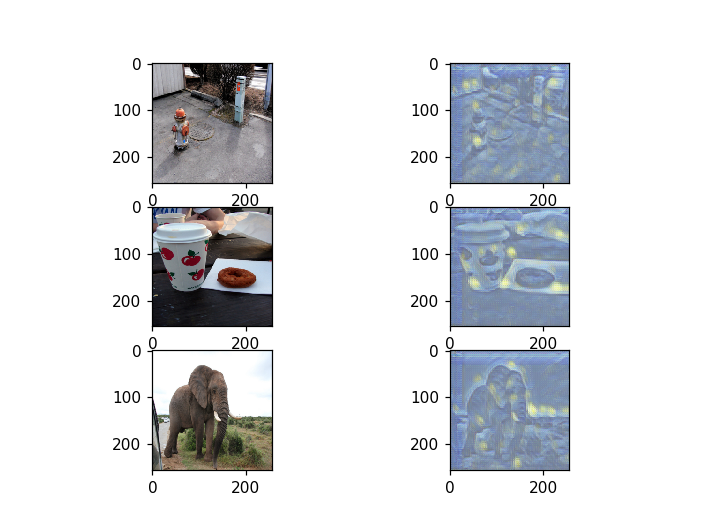

In [92]:
plt.figure(7)
plt.subplot(3,2,1)
plt.imshow(recover_image(x.detach().cpu().numpy())[0])

plt.subplot(3,2,2)
plt.imshow(recover_image(out_img_x.detach().cpu().numpy())[0])

plt.subplot(3,2,3)
plt.imshow(recover_image(y.detach().cpu().numpy())[0])

plt.subplot(3,2,4)
plt.imshow(recover_image(out_img_y.detach().cpu().numpy())[0])

plt.subplot(3,2,5)
plt.imshow(recover_image(z.detach().cpu().numpy())[0])

plt.subplot(3,2,6)
plt.imshow(recover_image(out_img_z.detach().cpu().numpy())[0])



In [93]:
torch.save(gen_resnet.state_dict(), './ResNetTrained')

In [96]:
new_net = ResNetGen(3,3,32,"reflect","BatchNorm",False,5,2)
new_net.load_state_dict(torch.load('./ResNetTrained'))
new_net.eval()
new_net.to(device)

ResNetGen(
  (net): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): ResidualBlock(
      (forward_func): Sequential(
        (0): ConvLayer(
          (forward_func): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
   

In [97]:
out_img_x = new_net(x)
out_img_y = new_net(y)
out_img_z = new_net(z)

<IPython.core.display.Javascript object>


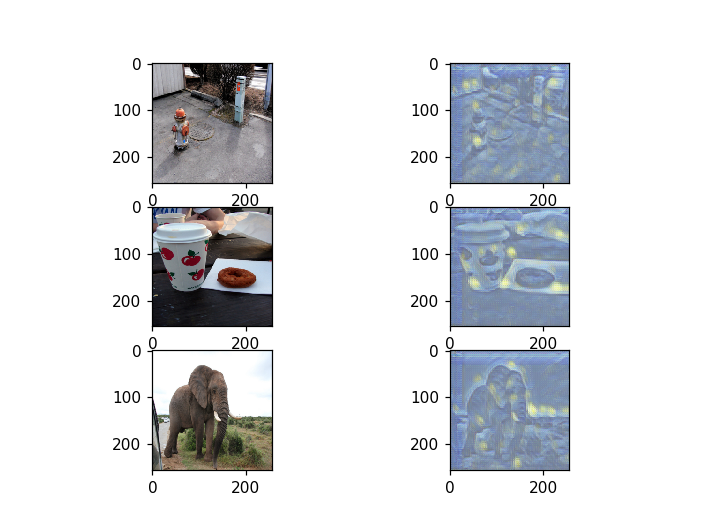

In [98]:
plt.figure(8)
plt.subplot(3,2,1)
plt.imshow(recover_image(x.detach().cpu().numpy())[0])

plt.subplot(3,2,2)
plt.imshow(recover_image(out_img_x.detach().cpu().numpy())[0])

plt.subplot(3,2,3)
plt.imshow(recover_image(y.detach().cpu().numpy())[0])

plt.subplot(3,2,4)
plt.imshow(recover_image(out_img_y.detach().cpu().numpy())[0])

plt.subplot(3,2,5)
plt.imshow(recover_image(z.detach().cpu().numpy())[0])

plt.subplot(3,2,6)
plt.imshow(recover_image(out_img_z.detach().cpu().numpy())[0])